# Using CT for thermosensitivity analysis: Real data

This notebook uses real data from the real world.

The data used comes from schools buildings. Hence, it shows a large variety of occupancy:
- usual school days
- usual weekends
- Wednesdays can differ from the other days
- Bank holidays
- school holidays either closed, or with another occupancy (think of a summer camp)


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

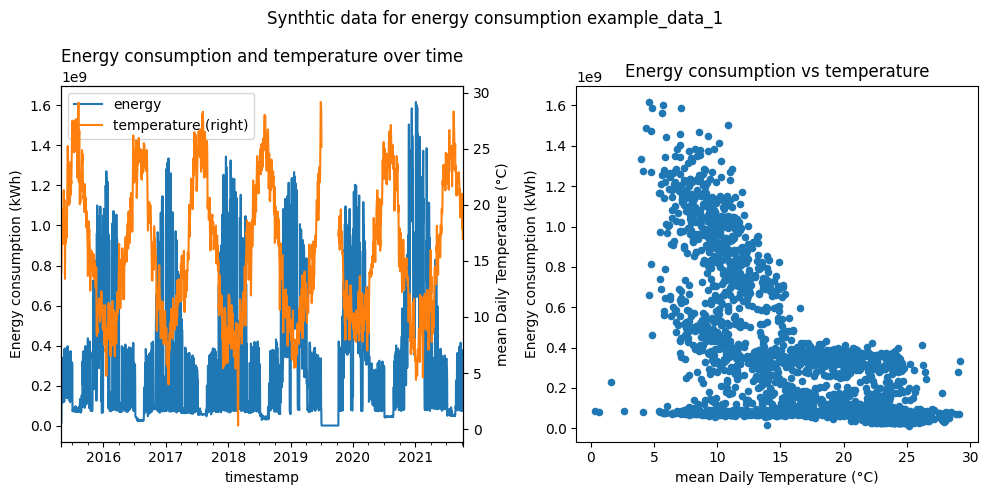

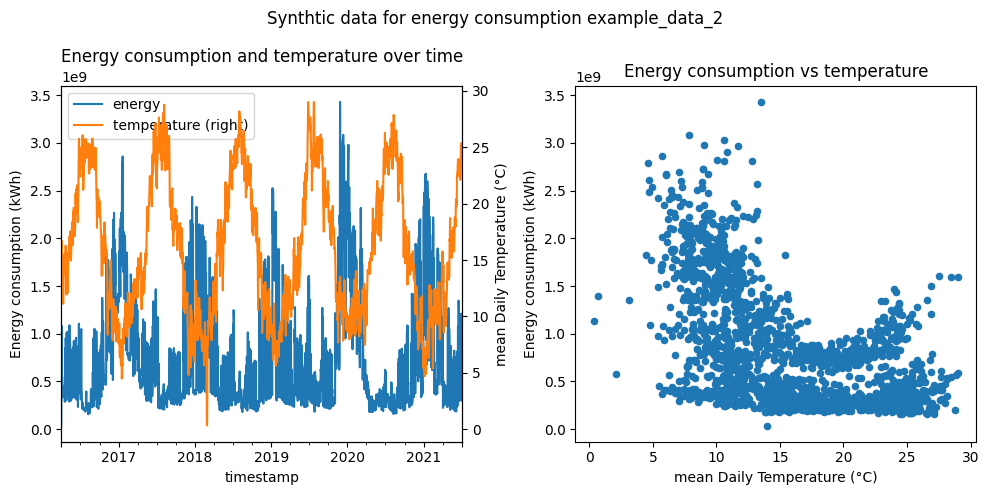

In [2]:
files = ["data/example_data_1.parquet", "data/example_data_2.parquet"]

for file in files:
    data = pd.read_parquet(file)
    data = data.resample("1D").agg({"energy": "sum", "temperature": "mean"})
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
    data[["energy"]].plot(ax=ax1)
    data[["temperature"]].plot(ax=ax1, secondary_y=True)
    ax1.set_ylabel("Energy consumption (kWh)")
    ax1.right_ax.set_ylabel("mean Daily Temperature (°C)")

    data.plot.scatter(x="temperature", y="energy", ax=ax2)
    ax2.set_xlabel("mean Daily Temperature (°C)")
    ax2.set_ylabel("Energy consumption (kWh)")
    ax1.set_title("Energy consumption and temperature over time")
    ax2.set_title("Energy consumption vs temperature")
    fig.suptitle(
        "Synthtic data for energy consumption " + file.split("/")[-1].split(".")[0]
    )
    fig.tight_layout()

# Thermo-sensitivity analysis

The main objective of the analysis is to explain the impact of the temperature over the energy.

Each category of occupancy can be modeled with a thermosensitivity model by:
- finding the threshold temperatures for heating and cooling
- finding the three coefficients $E_0$, $TS_{cooling}$ and $TS_{heating}$ such that
    $$ E = E_0 + TS_{cooling} * DD_{cooling}  + TS_{heating} * DD_{heating} $$ 

But this must be done for all the different (unlabeled) categories.

## Modeling the Weekly energy

The first step is to model the weekly energy consumption. This is done by passing the frequencu "7D" to the ThermoSensitivity class.

Processing weekly data is a good way to get a first idea of the thermosensitivity of the building without being too much influenced by the daily variations.

In [3]:
from energy_toolbox.thermosensitivity import ThermoSensitivity

In [4]:
data = pd.read_parquet(files[0])
start = data.index[0]
first_monday = start + pd.DateOffset(weekday=0, hour=0, minute=0, second=0)
data = data.loc[first_monday:]
data.head()

,duration,energy,holidays,temperature
timestamp,,,,
2015-05-04 00:00:00+02:00,600000.0,600000.0,True,15.800000
2015-05-04 00:10:00+02:00,600000.0,1200000.0,True,15.766667
2015-05-04 00:20:00+02:00,600000.0,1200000.0,True,15.733333
2015-05-04 00:30:00+02:00,600000.0,1200000.0,True,15.700000
2015-05-04 00:40:00+02:00,600000.0,600000.0,True,15.666667


In [5]:
ts = ThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["temperature"],
    frequency="7D",
    degree_days_type="auto",
    degree_days_computation_method="integral",
)

In [6]:
ts.fit()
ts.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     421.2
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           2.21e-60
Time:                        11:43:33   Log-Likelihood:                -7243.9
No. Observations:                 323   AIC:                         1.449e+04
Df Residuals:                     321   BIC:                         1.450e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
heating_degree_days  6.991e+07   3.41e+06     20.523      0.000    6.32e+07    7.66e+07
Intercept            1.089e+09   1.01e+08     10.746      0.000     8.9e+08    1.29e+09
==============================================================================
Omnibus:                       46.497   Durbin-Watson:                   0.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.523
Skew:                          -0.649   Prob(JB):                     4.54e-29
Kurtosis:                       5.831   Cond. No.                         40.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
ts.aggregated_data

,energy,temperature,heating_degree_days
timestamp,,,
2015-05-04 00:00:00+02:00,8.418000e+08,18.067510,2.365944
2015-05-11 00:00:00+02:00,1.519200e+09,19.319345,1.547856
2015-05-18 00:00:00+02:00,1.975200e+09,17.227480,4.530394
2015-05-25 00:00:00+02:00,1.726800e+09,17.525794,2.079876
2015-06-01 00:00:00+02:00,1.925400e+09,22.076042,0.111308
...,...,...,...
2021-09-06 00:00:00+02:00,1.674000e+09,22.365526,0.000000
2021-09-13 00:00:00+02:00,1.678800e+09,21.557242,0.000000
2021-09-20 00:00:00+02:00,1.786200e+09,19.917758,0.473862


Text(0.5, 0, 'Date')

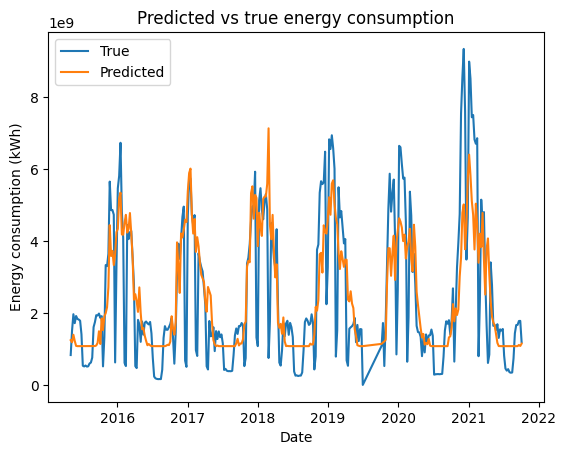

In [8]:
predictions = ts.model.predict()

fig, ax = plt.subplots()
aggregated_data = ts.aggregated_data.dropna(how="any", axis=0)
ax.plot(aggregated_data.index, aggregated_data["energy"], label="True")
ax.plot(aggregated_data.index, predictions, label="Predicted")
ax.legend()
ax.set_title("Predicted vs true energy consumption")
ax.set_ylabel("Energy consumption (kWh)")
ax.set_xlabel("Date")

Text(0.5, 1.0, 'Energy consumption vs temperature')

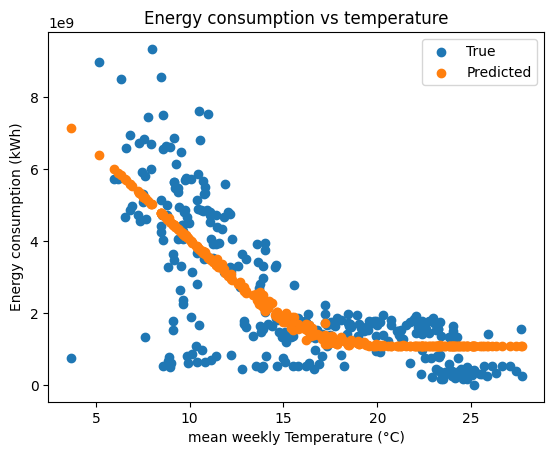

In [9]:
fig, ax = plt.subplots()

ax.scatter(aggregated_data["temperature"], aggregated_data["energy"], label="True")
ax.scatter(aggregated_data["temperature"], predictions, label="Predicted")
ax.legend()
ax.set_xlabel("mean weekly Temperature (°C)")
ax.set_ylabel("Energy consumption (kWh)")
ax.set_title("Energy consumption vs temperature")

Text(0.5, 1.0, 'Energy consumption vs temperature')

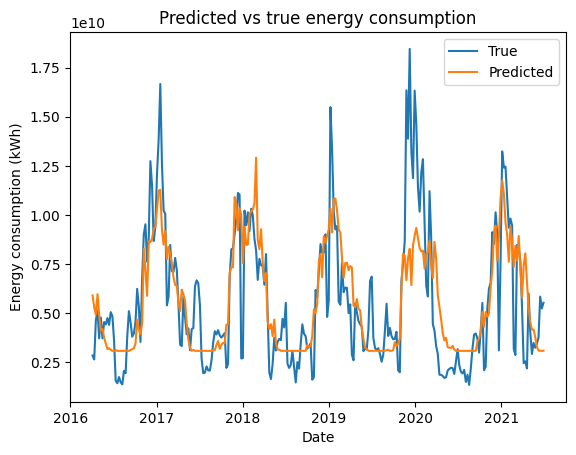

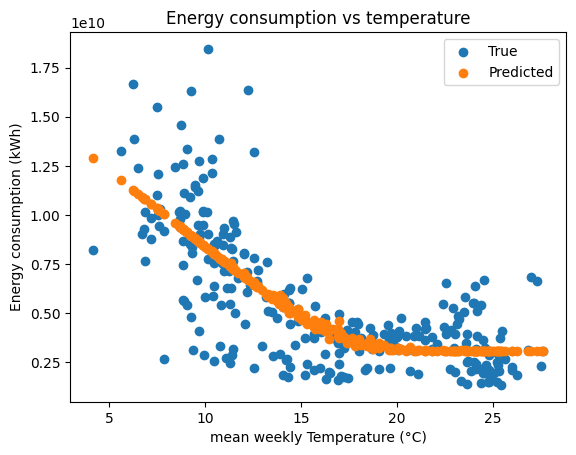

In [10]:
data2 = pd.read_parquet(files[1])
start = data2.index[0]
first_monday = start + pd.DateOffset(weekday=0, hour=0, minute=0, second=0)
data2 = data2.loc[first_monday:]
ts2 = ThermoSensitivity(
    energy_data=data2["energy"],
    temperature_data=data2["temperature"],
    frequency="7D",
    degree_days_type="auto",
    degree_days_computation_method="integral",  # here the provided data is already in daily frequency. Hence the only mean
)
ts2.fit()
predictions2 = ts2.model.predict()

fig, ax = plt.subplots()
aggregated_data = ts2.aggregated_data.dropna(how="any", axis=0)
ax.plot(aggregated_data.index, aggregated_data["energy"], label="True")
ax.plot(aggregated_data.index, predictions2, label="Predicted")
ax.legend()
ax.set_title("Predicted vs true energy consumption")
ax.set_ylabel("Energy consumption (kWh)")
ax.set_xlabel("Date")

fig, ax = plt.subplots()
ax.scatter(aggregated_data["temperature"], aggregated_data["energy"], label="True")
ax.scatter(aggregated_data["temperature"], predictions2, label="Predicted")
ax.legend()
ax.set_xlabel("mean weekly Temperature (°C)")
ax.set_ylabel("Energy consumption (kWh)")
ax.set_title("Energy consumption vs temperature")

## Conclusion of Weekly Analysis

As you can see above, the model is able to fit the data quite well. The model is able to capture the heating and cooling needs of the building.

One limitation that we can observe is the drop in energy consumption during the summer. This is due to the fact that the building is closed during the summer. This is a limitation of the model as it is not able to capture the occupancy of the building.

# Modeling the Daily energy

The next step is to model the daily energy consumption. This is done by passing the frequency "1D" to the ThermoSensitivity class.

However, the daily data is more complex to model as it is influenced by the occupancy of the building.

timestamp
2016-02-01 00:00:00+01:00    Open
2016-02-01 00:10:00+01:00    Open
2016-02-01 00:20:00+01:00    Open
2016-02-01 00:30:00+01:00    Open
2016-02-01 00:40:00+01:00    Open
dtype: object

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     352.9
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          6.83e-155
Time:                        11:43:35   Log-Likelihood:                -20126.
No. Observations:                 974   AIC:                         4.026e+04
Df Residuals:                     970   BIC:                         4.028e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
heating_degree_days:Closed  1.855e+06    4.2e+06      0.442      0.659   -6.39e+06    1.01e+07
heating_degree_days:Open    6.648e+07   2.57e+06     25.819      0.000    6.14e+07    7.15e+07
Intercept:Closed            6.558e+07   1.75e+07      3.756      0.000    3.13e+07    9.98e+07
Intercept:Open              2.124e+08   1.11e+07     19.157      0.000    1.91e+08    2.34e+08
==============================================================================
Omnibus:                      124.025   Durbin-Watson:                   1.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              375.035
Skew:                          -0.632   Prob(JB):                     3.65e-82
Kurtosis:                       5.765   Cond. No.                         8.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 0.98, 'Model with Weekend/Weekday categorisation')

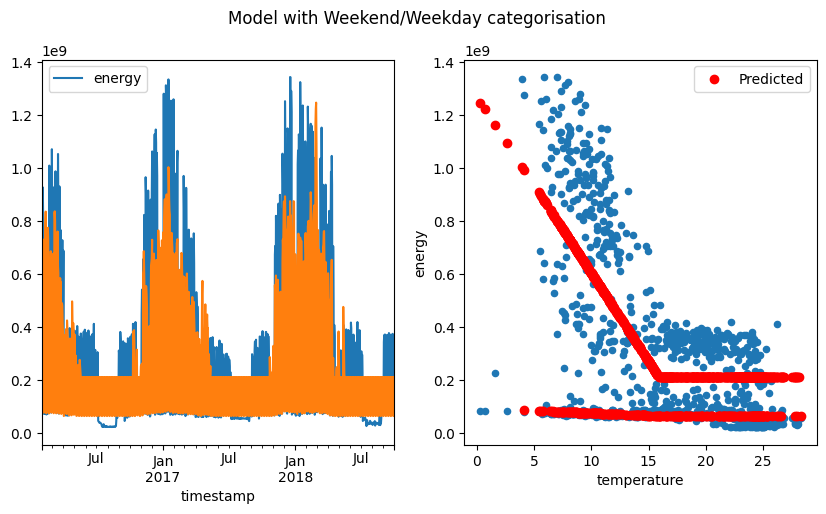

In [11]:
from energy_toolbox.thermosensitivity.thermosensitivity import (
    CategoricalThermoSensitivity,
)

data = pd.read_parquet(files[0]).loc[
    "2016-02-01":"2018-10-01"
]  # Selecting dates where the behaviour is more stable
start = data.index[0]
first_monday = start + pd.DateOffset(weekday=0, hour=0, minute=0, second=0)
data = data.loc[first_monday:]


def open_close_categoriser(series: pd.Series):
    """Return a series of categories based on the day of the week of the index"""
    timestamps = series.index
    return_data = pd.Series(
        data=[
            "Open" if timestamp.weekday() < 5 else "Closed" for timestamp in timestamps
        ],
        index=series.index,
    )
    return return_data


categories = open_close_categoriser(data)
display(categories.head())

ts_cat = CategoricalThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["temperature"],
    categories=categories,
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts_cat.fit()

display(ts_cat.model.summary())
predictions = ts_cat.model.predict()
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
aggregated_data = ts_cat.aggregated_data.dropna(how="any", axis=0)
aggregated_data[["energy"]].plot(ax=ax1)
ax1.plot(aggregated_data.index, predictions, label="Predicted")

aggregated_data.plot.scatter(x="temperature", y="energy", ax=ax2)
ax2.scatter(aggregated_data["temperature"], predictions, label="Predicted", color="red")
ax2.legend()
fig.suptitle("Model with Weekend/Weekday categorisation")

timestamp
2016-02-01 00:00:00+01:00    0
2016-02-01 00:10:00+01:00    0
2016-02-01 00:20:00+01:00    0
2016-02-01 00:30:00+01:00    0
2016-02-01 00:40:00+01:00    0
dtype: int64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     111.0
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          6.43e-181
Time:                        11:43:36   Log-Likelihood:                -20039.
No. Observations:                 974   AIC:                         4.011e+04
Df Residuals:                     960   BIC:                         4.017e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
heating_degree_days:0.0  8.133e+07   5.36e+06     15.171      0.000    7.08e+07    9.18e+07
heating_degree_days:1.0  7.282e+07   5.28e+06     13.788      0.000    6.25e+07    8.32e+07
heating_degree_days:2.0  3.684e+07    5.1e+06      7.229      0.000    2.68e+07    4.68e+07
heating_degree_days:3.0  7.318e+07   5.25e+06     13.931      0.000    6.29e+07    8.35e+07
heating_degree_days:4.0  7.303e+07   5.48e+06     13.315      0.000    6.23e+07    8.38e+07
heating_degree_days:5.0  1.907e+06   5.43e+06      0.351      0.725   -8.75e+06    1.26e+07
heating_degree_days:6.0    1.8e+06   5.49e+06      0.328      0.743   -8.97e+06    1.26e+07
Intercept:0.0            2.402e+08   2.28e+07     10.552      0.000    1.96e+08    2.85e+08
Intercept:1.0            2.414e+08   2.27e+07     10.613      0.000    1.97e+08    2.86e+08
Intercept:2.0            1.054e+08   2.27e+07      4.637      0.000    6.08e+07     1.5e+08
Intercept:3.0             2.33e+08   2.28e+07     10.215      0.000    1.88e+08    2.78e+08
Intercept:4.0             2.32e+08   2.29e+07     10.143      0.000    1.87e+08    2.77e+08
Intercept:5.0            6.622e+07   2.27e+07      2.919      0.004    2.17e+07    1.11e+08
Intercept:6.0            6.494e+07   2.27e+07      2.863      0.004    2.04e+07    1.09e+08
==============================================================================
Omnibus:                      330.600   Durbin-Watson:                   0.781
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1675.453
Skew:                          -1.482   Prob(JB):                         0.00
Kurtosis:                       8.701   Cond. No.                         5.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 0.98, 'Model with Day of Week categorisation (Monday, etc.)')

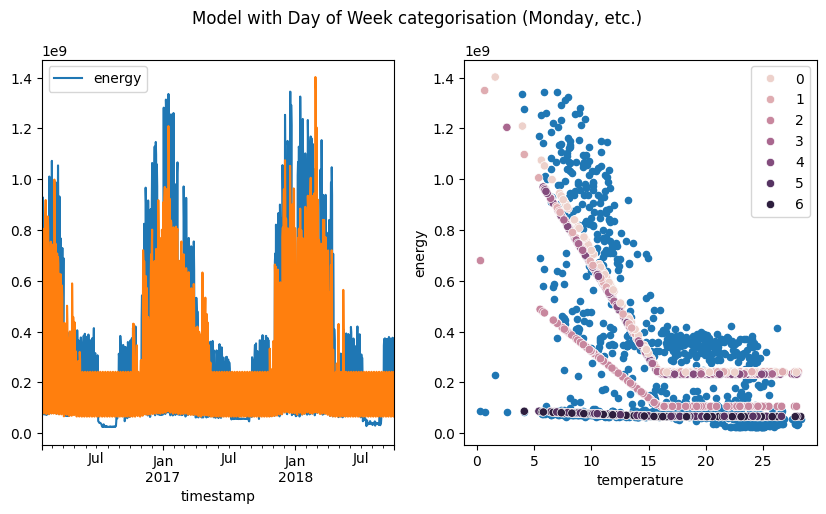

In [12]:
data = pd.read_parquet(files[0]).loc[
    "2016-02-01":"2018-10-01"
]  # Selecting dates where the behaviour is more stable


def dayofweek_categoriser(series: pd.Series):
    """Return a series of categories based on the day of the week of the index"""
    timestamps = series.index
    return_data = pd.Series(
        data=[timestamp.weekday() for timestamp in timestamps],
        index=series.index,
    )
    return return_data


categories = dayofweek_categoriser(data)
display(categories.head())

ts_cat = CategoricalThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["temperature"],
    categories=categories,
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts_cat.fit()

display(ts_cat.model.summary())
predictions = ts_cat.model.predict()
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
aggregated_data = ts_cat.aggregated_data.dropna(how="any", axis=0)
aggregated_data[["energy"]].plot(ax=ax1)
ax1.plot(aggregated_data.index, predictions, label="Predicted")

aggregated_data.plot.scatter(x="temperature", y="energy", ax=ax2)
sns.scatterplot(
    x=aggregated_data["temperature"], y=predictions, hue=aggregated_data["category"]
)
ax2.legend()
fig.suptitle("Model with Day of Week categorisation (Monday, etc.)")

timestamp
2017-06-01 00:00:00+02:00    Open
2017-06-01 00:10:00+02:00    Open
2017-06-01 00:20:00+02:00    Open
2017-06-01 00:30:00+02:00    Open
2017-06-01 00:40:00+02:00    Open
dtype: object

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     346.1
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          1.47e-139
Time:                        11:43:37   Log-Likelihood:                -15439.
No. Observations:                 731   AIC:                         3.089e+04
Df Residuals:                     727   BIC:                         3.090e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
heating_degree_days:Closed  2.833e+07   6.95e+06      4.078      0.000    1.47e+07     4.2e+07
heating_degree_days:Open    1.062e+08   4.23e+06     25.095      0.000    9.79e+07    1.15e+08
Intercept:Closed             2.67e+08   3.29e+07      8.113      0.000    2.02e+08    3.32e+08
Intercept:Open              5.864e+08   2.11e+07     27.728      0.000    5.45e+08    6.28e+08
==============================================================================
Omnibus:                       30.135   Durbin-Watson:                   0.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.470
Skew:                           0.099   Prob(JB):                     5.54e-18
Kurtosis:                       4.603   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 0.98, 'Model with Weekend/Weekday categorisation')

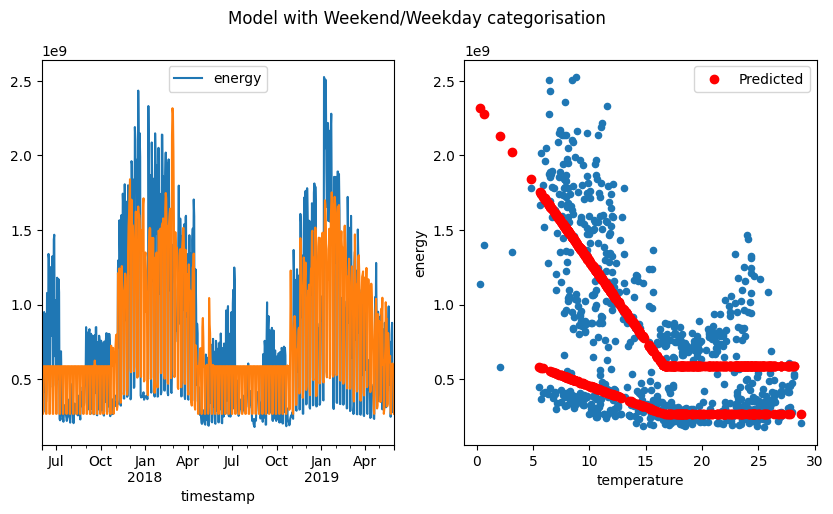

In [13]:
data2 = pd.read_parquet(files[1]).loc[
    "2017-06-01":"2019-06-01"
]  # Selecting dates where the behaviour is more stable


def open_close_categoriser(series: pd.Series):
    """Return a series of categories based on the day of the week of the index"""
    timestamps = series.index
    return_data = pd.Series(
        data=[
            "Open" if timestamp.weekday() < 5 else "Closed" for timestamp in timestamps
        ],
        index=series.index,
    )
    return return_data


categories = open_close_categoriser(data2)
display(categories.head())

ts_cat = CategoricalThermoSensitivity(
    energy_data=data2["energy"],
    temperature_data=data2["temperature"],
    categories=categories,
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts_cat.fit()

display(ts_cat.model.summary())
predictions = ts_cat.model.predict()
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
aggregated_data = ts_cat.aggregated_data.dropna(how="any", axis=0)
aggregated_data[["energy"]].plot(ax=ax1)
ax1.plot(aggregated_data.index, predictions, label="Predicted")

aggregated_data.plot.scatter(x="temperature", y="energy", ax=ax2)
ax2.scatter(aggregated_data["temperature"], predictions, label="Predicted", color="red")
ax2.legend()
fig.suptitle("Model with Weekend/Weekday categorisation")

In [14]:
data2

,duration,energy,holidays,temperature
timestamp,,,,
2017-06-01 00:00:00+02:00,600000.0,1800000.0,False,20.200000
2017-06-01 00:10:00+02:00,600000.0,2400000.0,False,20.133333
2017-06-01 00:20:00+02:00,600000.0,2400000.0,False,20.066667
2017-06-01 00:30:00+02:00,600000.0,1800000.0,False,20.000000
2017-06-01 00:40:00+02:00,600000.0,2400000.0,False,19.933333
...,...,...,...,...
2019-06-01 23:10:00+02:00,600000.0,1200000.0,False,17.483333
2019-06-01 23:20:00+02:00,600000.0,1800000.0,False,17.366667
2019-06-01 23:30:00+02:00,600000.0,1800000.0,False,17.250000


timestamp
2017-06-01 00:00:00+02:00    3
2017-06-01 00:10:00+02:00    3
2017-06-01 00:20:00+02:00    3
2017-06-01 00:30:00+02:00    3
2017-06-01 00:40:00+02:00    3
dtype: int64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     97.27
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          1.89e-148
Time:                        11:43:38   Log-Likelihood:                -15392.
No. Observations:                 731   AIC:                         3.081e+04
Df Residuals:                     717   BIC:                         3.088e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
heating_degree_days:0.0  1.128e+08   9.15e+06     12.320      0.000    9.48e+07    1.31e+08
heating_degree_days:1.0  1.058e+08   8.86e+06     11.950      0.000    8.85e+07    1.23e+08
heating_degree_days:2.0  9.898e+07   8.71e+06     11.358      0.000    8.19e+07    1.16e+08
heating_degree_days:3.0  1.096e+08   8.72e+06     12.564      0.000    9.24e+07    1.27e+08
heating_degree_days:4.0  1.093e+08   9.29e+06     11.762      0.000    9.11e+07    1.28e+08
heating_degree_days:5.0  2.839e+07   9.33e+06      3.043      0.002    1.01e+07    4.67e+07
heating_degree_days:6.0  2.828e+07   9.22e+06      3.067      0.002    1.02e+07    4.64e+07
Intercept:0.0            6.692e+08   4.47e+07     14.964      0.000    5.81e+08    7.57e+08
Intercept:1.0            6.575e+08   4.51e+07     14.591      0.000    5.69e+08    7.46e+08
Intercept:2.0            3.184e+08   4.52e+07      7.044      0.000     2.3e+08    4.07e+08
Intercept:3.0            6.277e+08   4.42e+07     14.211      0.000    5.41e+08    7.14e+08
Intercept:4.0            6.426e+08   4.41e+07     14.565      0.000    5.56e+08    7.29e+08
Intercept:5.0            2.676e+08   4.36e+07      6.138      0.000    1.82e+08    3.53e+08
Intercept:6.0            2.663e+08   4.43e+07      6.017      0.000    1.79e+08    3.53e+08
==============================================================================
Omnibus:                       58.978   Durbin-Watson:                   0.679
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              247.407
Skew:                          -0.216   Prob(JB):                     1.89e-54
Kurtosis:                       5.817   Cond. No.                         7.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 0.98, 'Model with day of week categorisation (Monday, etc.)')

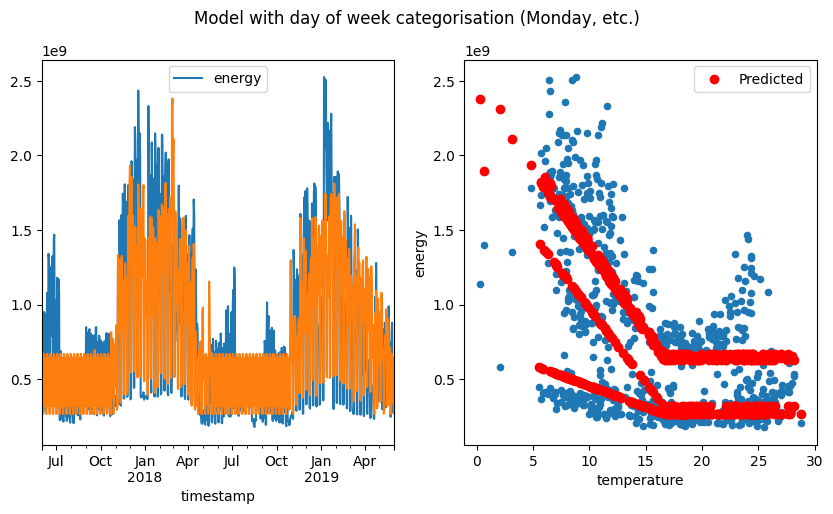

In [15]:
def dayofweek_categoriser(series: pd.Series):
    """Return a series of categories based on the day of the week of the index"""
    timestamps = series.index
    return_data = pd.Series(
        data=[timestamp.weekday() for timestamp in timestamps],
        index=series.index,
    )
    return return_data


categories = dayofweek_categoriser(data2)
display(categories.head())


ts_cat = CategoricalThermoSensitivity(
    energy_data=data2["energy"],
    temperature_data=data2["temperature"],
    categories=categories,
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts_cat.fit()

display(ts_cat.model.summary())
predictions = ts_cat.model.predict()
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
aggregated_data = ts_cat.aggregated_data.dropna(how="any", axis=0)
aggregated_data[["energy"]].plot(ax=ax1)
ax1.plot(aggregated_data.index, predictions, label="Predicted")

aggregated_data.plot.scatter(x="temperature", y="energy", ax=ax2)
ax2.scatter(aggregated_data["temperature"], predictions, label="Predicted", color="red")
ax2.legend()
fig.suptitle("Model with day of week categorisation (Monday, etc.)")

# Adding the school holidays

The previous categorisation of occupancy is not enough to explain the daily energy consumption. We need to add the school holidays to the model.

In [16]:
%pip install vacances-scolaires-france jours-feries-france

Looking in indexes: https://pypi.org/simple, https://gitlab.ecoco2.com/api/v4/groups/recherche/-/packages/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [17]:
from jours_feries_france import JoursFeries
from vacances_scolaires_france import SchoolHolidayDates

jf = JoursFeries()
shd = SchoolHolidayDates()


def is_bank_holiday(date):
    return jf.is_bank_holiday(date)


def is_holiday(date):
    return shd.is_holiday_for_zone(date, "B")


def school_open_close(series: pd.Series):
    """Return a series of categories based on the day of the week of the index"""
    timestamps = series.index
    is_open = []
    for timestamp in timestamps:
        if timestamp.weekday() > 4:
            is_open.append("weekend")
        elif is_bank_holiday(timestamp.date()):
            is_open.append("weekend")
        elif is_holiday(timestamp.date()):
            is_open.append("holiday")
        else:
            is_open.append("Open")
    return pd.Series(data=is_open, index=series.index)

In [18]:
data = pd.read_parquet(files[0]).loc[
    "2016-02-01":"2018-10-01"
]  # Selecting dates where the behaviour is more stable
categories = school_open_close(data)
display(categories.head())
display(categories.value_counts())

timestamp
2016-02-01 00:00:00+01:00    Open
2016-02-01 00:10:00+01:00    Open
2016-02-01 00:20:00+01:00    Open
2016-02-01 00:30:00+01:00    Open
2016-02-01 00:40:00+01:00    Open
dtype: object

Open       66240
weekend    43338
holiday    30672
Name: count, dtype: int64

In [19]:
ts_holidays = CategoricalThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["temperature"],
    categories=categories,
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts_holidays.fit()
display(ts_holidays.model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     877.3
Date:                Mon, 23 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:44:10   Log-Likelihood:                -19653.
No. Observations:                 974   AIC:                         3.932e+04
Df Residuals:                     968   BIC:                         3.935e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
heating_degree_days:Open     8.125e+07   1.96e+06     41.464      0.000    7.74e+07    8.51e+07
heating_degree_days:holiday  8.248e+06   2.87e+06      2.874      0.004    2.62e+06    1.39e+07
heating_degree_days:weekend  4.009e+06   2.52e+06      1.589      0.112   -9.42e+05    8.96e+06
Intercept:Open               2.965e+08   8.88e+06     33.375      0.000    2.79e+08    3.14e+08
Intercept:holiday            6.924e+07   1.12e+07      6.181      0.000    4.73e+07    9.12e+07
Intercept:weekend             6.59e+07   1.03e+07      6.403      0.000    4.57e+07    8.61e+07
==============================================================================
Omnibus:                      123.564   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              621.575
Skew:                          -0.462   Prob(JB):                    1.06e-135
Kurtosis:                       6.803   Cond. No.                         7.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

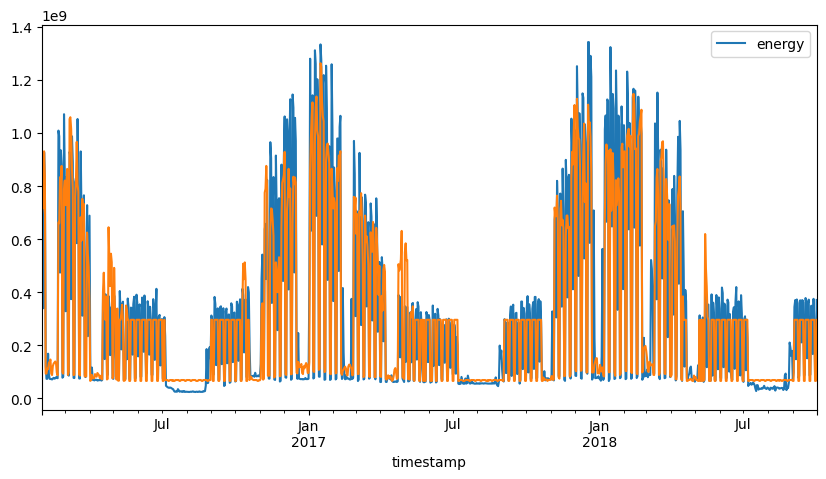

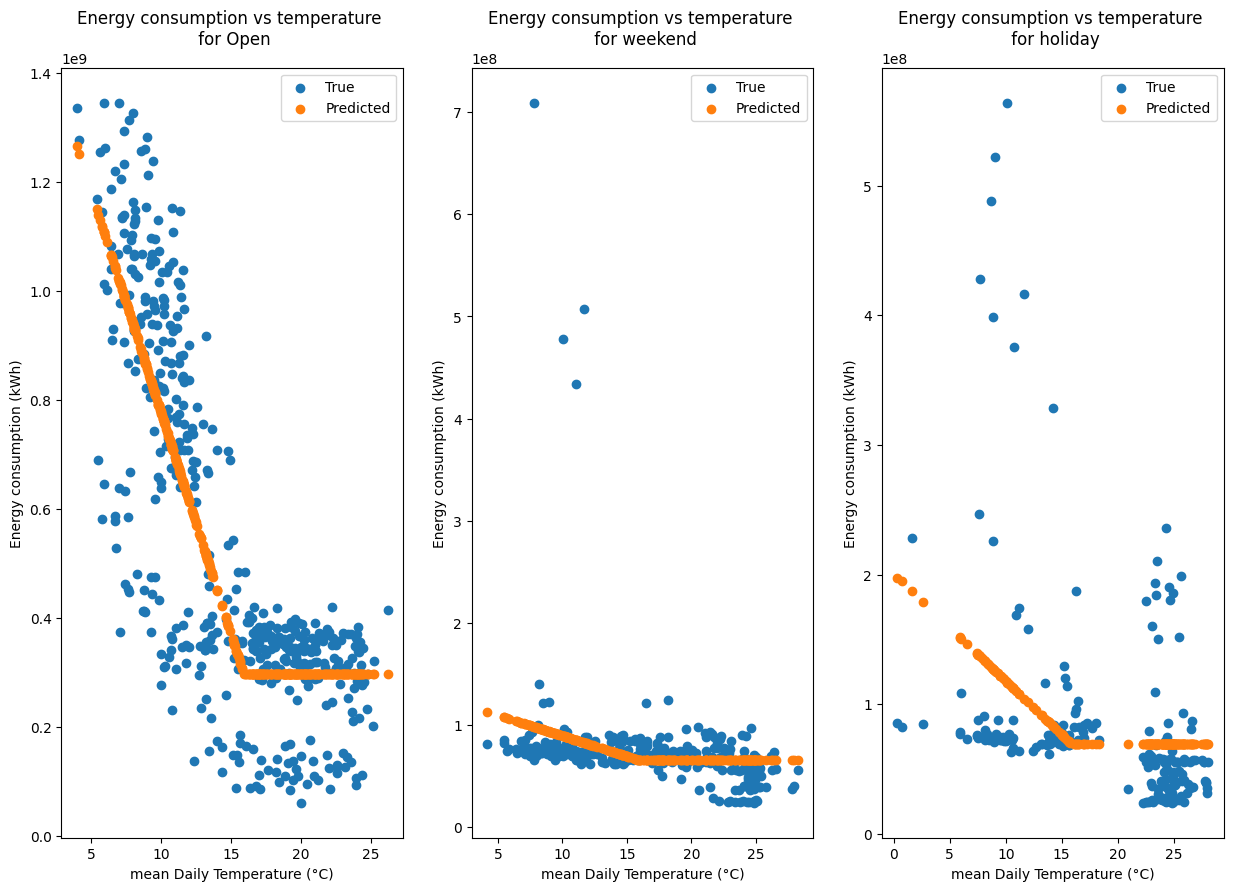

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
aggregated_data = ts_holidays.aggregated_data.dropna(how="any", axis=0)
aggregated_data[["energy"]].plot(ax=ax1)
predictions = ts_holidays.model.predict()

ax1.plot(aggregated_data.index, predictions, label="Predicted")

n_cat = len(categories.unique())
fig, axarr = plt.subplots(1, n_cat, figsize=(5 * n_cat, 10))
axarr = axarr.flatten() if n_cat > 1 else [axarr]
for i, cat in enumerate(categories.unique()):
    mask = aggregated_data["category"] == cat
    ax = axarr[i]
    ax.scatter(
        aggregated_data[mask]["temperature"],
        aggregated_data[mask]["energy"],
        label="True",
    )
    ax.scatter(
        aggregated_data[mask]["temperature"], predictions[mask], label="Predicted"
    )
    ax.set_title(f"Energy consumption vs temperature \n for {cat}")
    ax.set_xlabel("mean Daily Temperature (°C)")
    ax.set_ylabel("Energy consumption (kWh)")
    ax.legend()

In [21]:
categories2 = school_open_close(data2)
display(categories2.head())

timestamp
2017-06-01 00:00:00+02:00    Open
2017-06-01 00:10:00+02:00    Open
2017-06-01 00:20:00+02:00    Open
2017-06-01 00:30:00+02:00    Open
2017-06-01 00:40:00+02:00    Open
dtype: object

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     332.5
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          3.11e-236
Time:                        11:44:33   Log-Likelihood:                -15199.
No. Observations:                 731   AIC:                         3.042e+04
Df Residuals:                     722   BIC:                         3.046e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
heating_degree_days:Open     1.177e+08   3.85e+06     30.561      0.000     1.1e+08    1.25e+08
heating_degree_days:holiday  5.941e+07   6.18e+06      9.606      0.000    4.73e+07    7.16e+07
heating_degree_days:weekend  3.016e+07   5.08e+06      5.942      0.000    2.02e+07    4.01e+07
cooling_degree_days:Open     3.163e+08   8.13e+07      3.893      0.000    1.57e+08    4.76e+08
cooling_degree_days:holiday  3.339e+07   1.85e+07      1.800      0.072   -3.02e+06    6.98e+07
cooling_degree_days:weekend  1.371e+07    2.5e+07      0.548      0.584   -3.54e+07    6.28e+07
Intercept:Open               7.199e+08   2.05e+07     35.128      0.000     6.8e+08     7.6e+08
Intercept:holiday            3.007e+08   3.35e+07      8.974      0.000    2.35e+08    3.67e+08
Intercept:weekend            2.615e+08    2.5e+07     10.463      0.000    2.12e+08    3.11e+08
==============================================================================
Omnibus:                       96.161   Durbin-Watson:                   1.242
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              390.747
Skew:                           0.542   Prob(JB):                     1.41e-85
Kurtosis:                       6.414   Cond. No.                         31.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

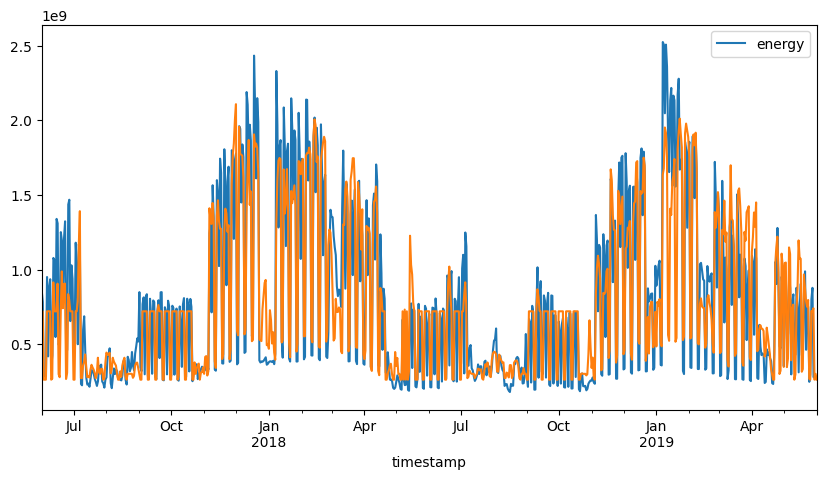

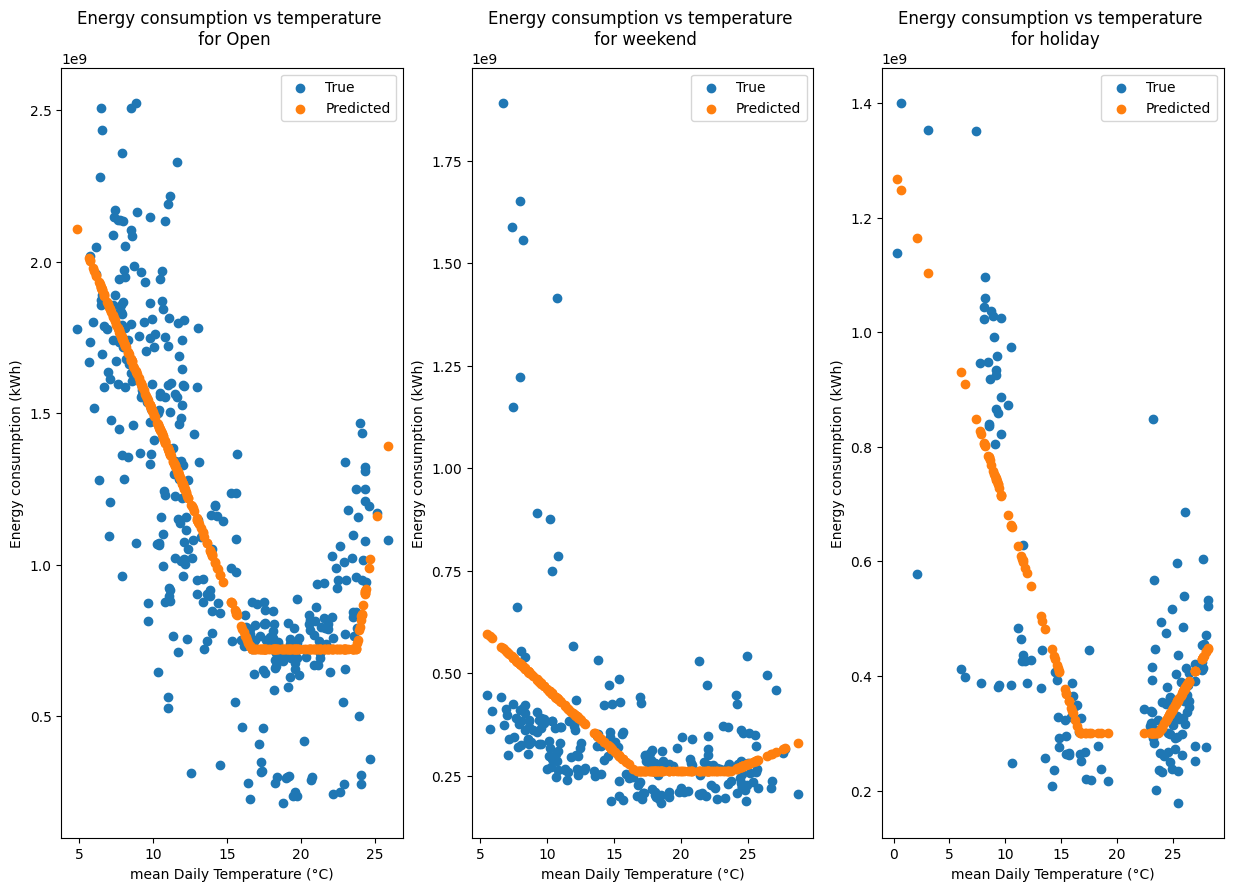

In [22]:
ts_holidays2 = CategoricalThermoSensitivity(
    energy_data=data2["energy"],
    temperature_data=data2["temperature"],
    categories=categories2,
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts_holidays2.fit()
display(ts_holidays2.model.summary())

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
aggregated_data = ts_holidays2.aggregated_data.dropna(how="any", axis=0)
aggregated_data[["energy"]].plot(ax=ax1)
predictions = ts_holidays2.model.predict()

ax1.plot(aggregated_data.index, predictions, label="Predicted")

n_cat = len(categories2.unique())
fig, axarr = plt.subplots(1, n_cat, figsize=(5 * n_cat, 10))
axarr = axarr.flatten() if n_cat > 1 else [axarr]
for i, cat in enumerate(categories2.unique()):
    mask = aggregated_data["category"] == cat
    ax = axarr[i]
    ax.scatter(
        aggregated_data[mask]["temperature"],
        aggregated_data[mask]["energy"],
        label="True",
    )
    ax.scatter(
        aggregated_data[mask]["temperature"], predictions[mask], label="Predicted"
    )
    ax.set_title(f"Energy consumption vs temperature \n for {cat}")
    ax.set_xlabel("mean Daily Temperature (°C)")
    ax.set_ylabel("Energy consumption (kWh)")
    ax.legend()

## Conclusion of Daily Analysis

Using no category, the model is not able to capture the occupancy of the building.
Using the day of week or the weekend is better, as more data is available for these categories, but their are some large discrepancies between the model and the data.

This may be due to the fact that the building is a school building and the school holidays are not taken into account.

## Automatic Day categorisation

The following section shows how to use the automatic days categorisation.

In [23]:
from pandas import DataFrame
from energy_toolbox.thermosensitivity.daily_analysis import (
    AutoCategoricalThermoSensitivity,
)


ts_auto = AutoCategoricalThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["temperature"],
    degree_days_type="auto",
    degree_days_computation_method="integral",
)
ts_auto.fit()
ts_auto

AutoCategoricalThermoSensitivity(frequency=1D,
        degree_days_type=heating,
        degree_days_base_temperature={'heating': np.float64(17.18)},
        degree_days_computation_method=integral,
        interseason_mean_temperature=20)

                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.601
No. Observations:                 974   F-statistic:                     113.5
Covariance Type:            nonrobust   Prob (F-statistic):          1.02e-183
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
heating_degree_days:Friday     6.519e+07   4.79e+06     13.601      0.000    5.58e+07    7.46e+07
heating_degree_days:Monday     7.269e+07   4.72e+06     15.399      0.

In [24]:
ts_auto.merge_and_fit()
ts_auto

AutoCategoricalThermoSensitivity(frequency=1D,
        degree_days_type=heating,
        degree_days_base_temperature={'heating': np.float64(17.18)},
        degree_days_computation_method=integral,
        interseason_mean_temperature=20)

                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.602
No. Observations:                 974   F-statistic:                     295.8
Covariance Type:            nonrobust   Prob (F-statistic):          4.58e-192
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
heating_degree_days:Monday-Tuesday-Thursday-Friday  6.705e+07   2.34e+06     28.593      0.000    6.24e+07    7.16e+07
heating

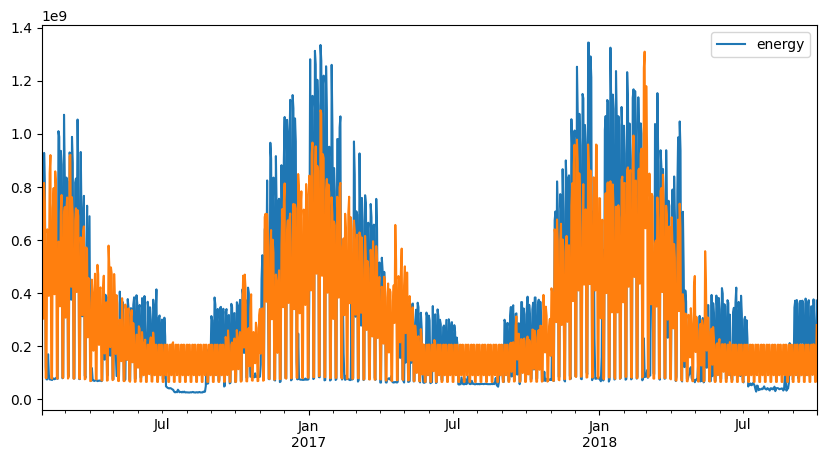

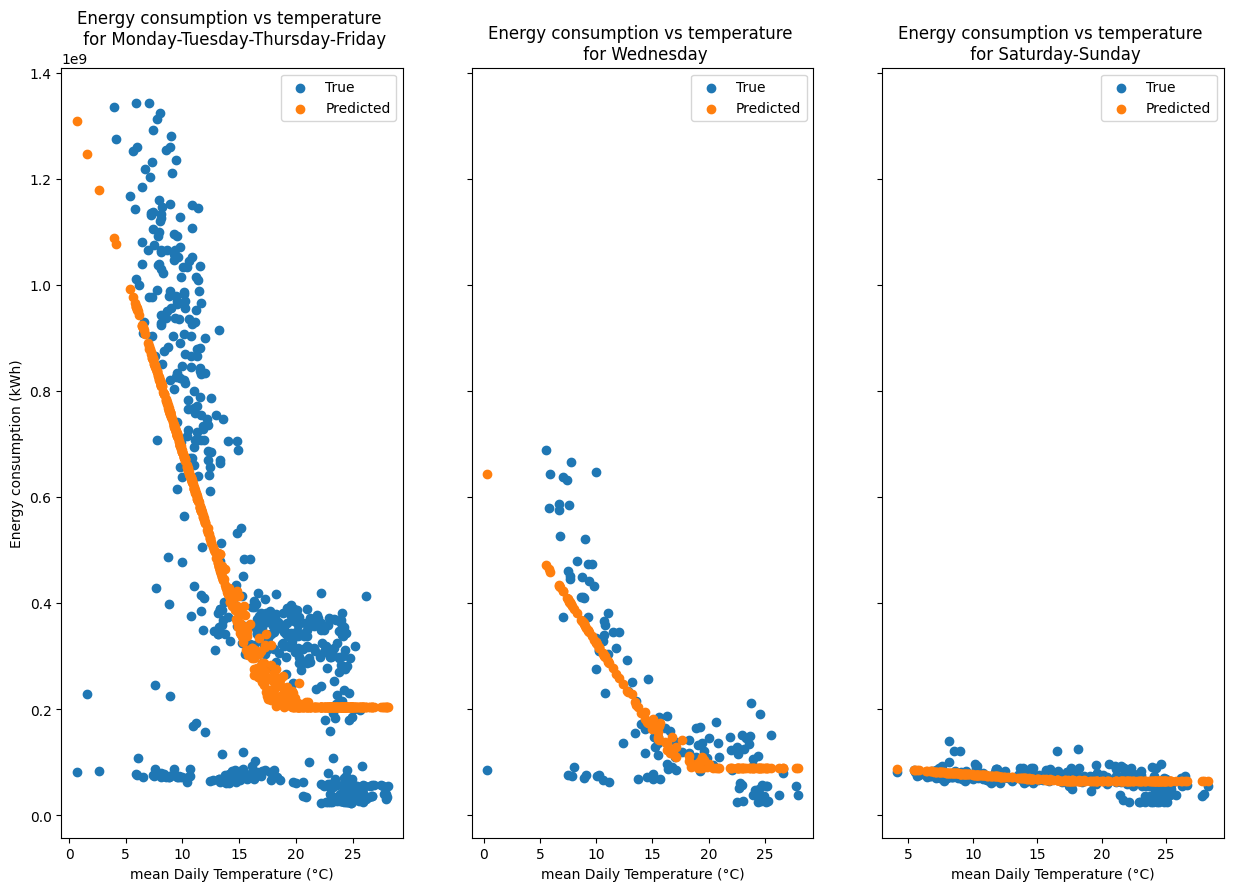

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
aggregated_data = ts_auto.aggregated_data.dropna(how="any", axis=0)
aggregated_data[["energy"]].plot(ax=ax1)
predictions = ts_auto.model.predict()

ax1.plot(aggregated_data.index, predictions, label="Predicted")

n_cat = len(ts_auto.resampled_categories.unique())
fig, axarr = plt.subplots(1, n_cat, figsize=(5 * n_cat, 10), sharey=True)
axarr = axarr.flatten() if n_cat > 1 else [axarr]
for i, cat in enumerate(ts_auto.resampled_categories.unique()):
    mask = aggregated_data["category"] == cat
    ax = axarr[i]
    ax.scatter(
        aggregated_data[mask]["temperature"],
        aggregated_data[mask]["energy"],
        label="True",
    )
    ax.scatter(
        aggregated_data[mask]["temperature"], predictions[mask], label="Predicted"
    )
    ax.set_title(f"Energy consumption vs temperature \n for {cat}")
    ax.set_xlabel("mean Daily Temperature (°C)")
    if i == 0:
        ax.set_ylabel("Energy consumption (kWh)")
    ax.legend()

In [26]:
ts_auto2 = AutoCategoricalThermoSensitivity(
    energy_data=data2["energy"],
    temperature_data=data2["temperature"],
    degree_days_type="auto",
    degree_days_computation_method="integral",
)
ts_auto2.fit()
ts_auto2.merge_and_fit()
ts_auto2

AutoCategoricalThermoSensitivity(frequency=1D,
        degree_days_type=heating,
        degree_days_base_temperature={'heating': np.float64(17.97)},
        degree_days_computation_method=integral,
        interseason_mean_temperature=20)

                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.627
No. Observations:                 731   F-statistic:                     246.3
Covariance Type:            nonrobust   Prob (F-statistic):          1.33e-153
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
heating_degree_days:Monday-Tuesday-Thursday-Friday  9.722e+07   4.06e+06     23.941      0.000    8.92e+07    1.05e+08
heating

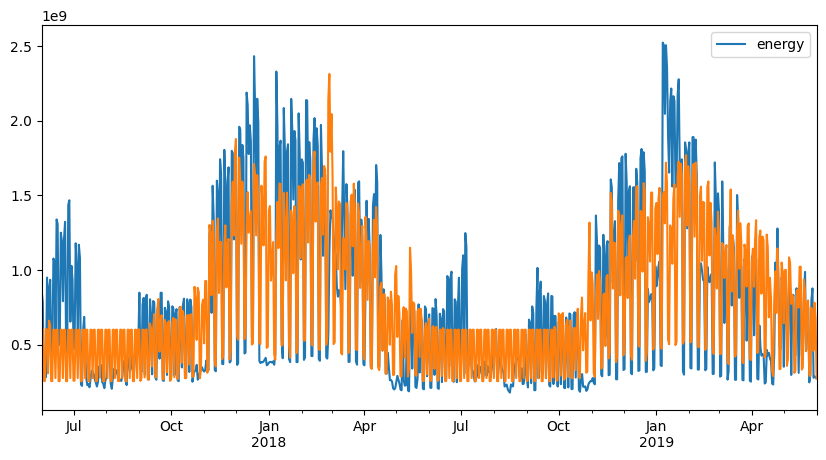

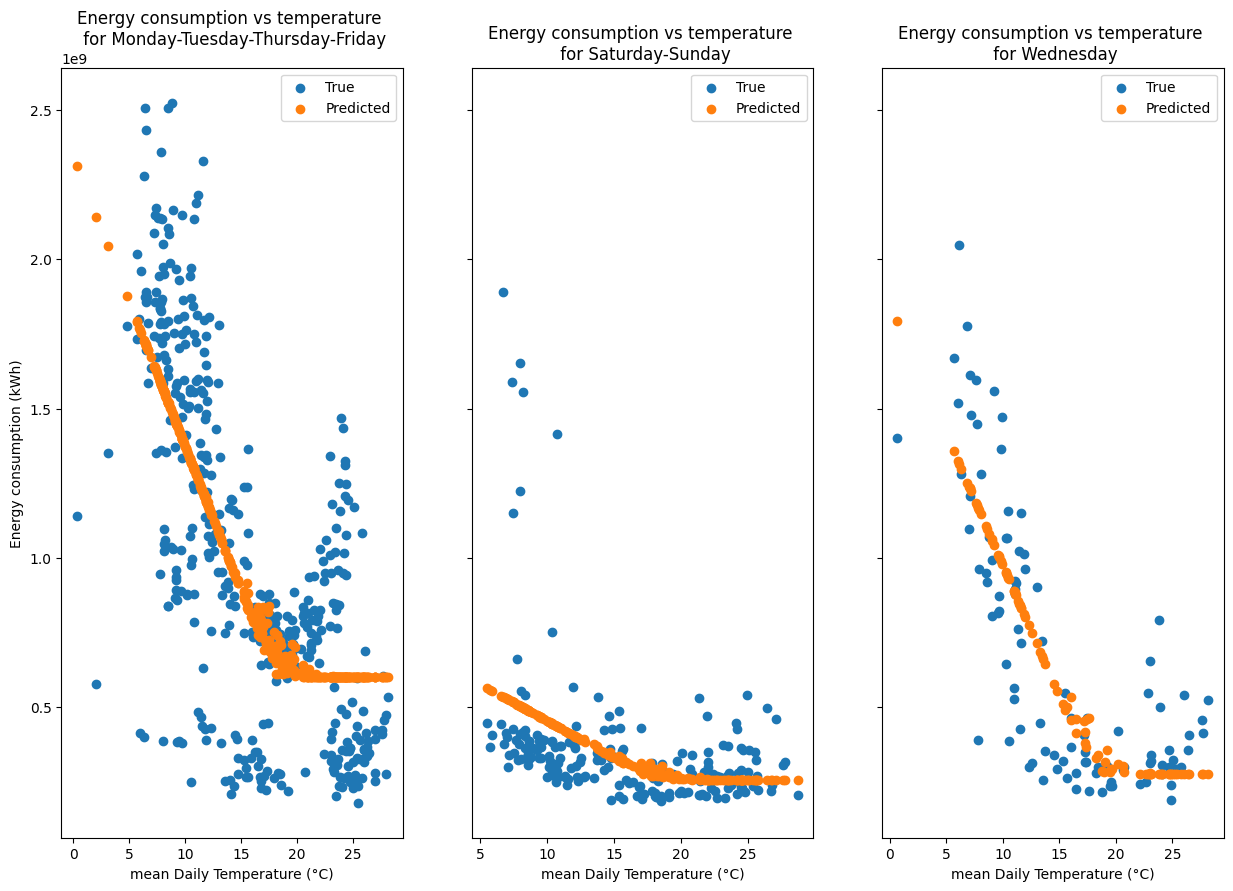

In [27]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
aggregated_data = ts_auto2.aggregated_data.dropna(how="any", axis=0)
aggregated_data[["energy"]].plot(ax=ax1)
predictions = ts_auto2.model.predict()

ax1.plot(aggregated_data.index, predictions, label="Predicted")

n_cat = len(ts_auto2.resampled_categories.unique())
fig, axarr = plt.subplots(1, n_cat, figsize=(5 * n_cat, 10), sharey=True)
axarr = axarr.flatten() if n_cat > 1 else [axarr]
for i, cat in enumerate(ts_auto2.resampled_categories.unique()):
    mask = aggregated_data["category"] == cat
    ax = axarr[i]
    ax.scatter(
        aggregated_data[mask]["temperature"],
        aggregated_data[mask]["energy"],
        label="True",
    )
    ax.scatter(
        aggregated_data[mask]["temperature"], predictions[mask], label="Predicted"
    )
    ax.set_title(f"Energy consumption vs temperature \n for {cat}")
    ax.set_xlabel("mean Daily Temperature (°C)")
    if i == 0:
        ax.set_ylabel("Energy consumption (kWh)")
    ax.legend()

## Conclusion of Automatic Day categorisation

As you can see, the model is able to detect that the building has three different occupancy categories:
- usual school days Monday, Tuesday, Thursday, Friday
- usual weekends Saturday, Sunday
- Wednesdays

However, the effect of the Hollidays is not taken into account in this implementation.

# Conclusion

As you can see, in contrast with synthetic data, the different days behaviors due to different building occupancy leads to multiple thermosensitivity model.

## Discussion / Next steps

The next step would be to improve the classifications.
For instance, we can re-label the periods according to the observed energy consumption. 
One way to do so is the following:
- compute the predicted energy consumption of the period for each category
- estimate the probability of each category given the energy consumption of the period and the standard deviation of the energy consumption of the category
- re-label the periods with the category with the highest probability (Max a posteriori estimation)

However, this cannot be used to detecte unexpected occupancy, on the contrary.

Another way would be an unsupervised classification of the periods. But for now this is a be too complex for the model.